In [14]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pymc as pm
from aux_functions.mcmc_transformations import (import_dataset, transform_variables, pop_variable, convert_to_float, normalize_dataset)
from aux_functions.mcmc_corr_matrix import (get_ordered_correlation_matrix, plot_correlation_matrix)
from aux_functions.mcmc_modelling import (get_list_with_specified_dfs, get_list_with_pm_models)


In [15]:
# Importing dataset
path = "data/dataset.txt"
column_names = ['lenght_of_stay', 'age', 'infection_risk', 'routine_culturing_ratio', 'routine_xray_ratio', 'num_beds', 'med_school_affil', 'region', 'avg_census', 'num_nurses', 'avelbl_services']
columns_to_dummify = ['med_school_affil', 'region']
columns_to_apply_ln = ['num_nurses', 'num_beds', 'avg_census']
result_path = './imgs/results/'
target_variable = 'infection_risk'

In [16]:
df = import_dataset(path, column_names)
df = transform_variables(df, columns_to_dummify, columns_to_apply_ln)
corr_matrix = get_ordered_correlation_matrix(df, target_variable)
plot_correlation_matrix(corr_matrix, result_path)
X, y = pop_variable(df, target_variable)
X = convert_to_float(X)
y = convert_to_float(y)
X = normalize_dataset(X)

In [17]:
# See the table in the report for the specified variables in each df
# Order of list: [complete, top_8, top_5, top_4, top_3, top_2]
dfs = get_list_with_specified_dfs(X) 

In [18]:
def is_proposal_distribution_cauchy(y_proposal_distribution):
    return True if y_proposal_distribution == "cauchy" else False

def is_proposal_distribution_student(y_proposal_distribution):
    return True if y_proposal_distribution == "student_t" else False

def is_proposal_distribution_normal(y_proposal_distribution):
    return True if y_proposal_distribution == "normal" else False

In [19]:
def get_models(dfs, y, y_proposal_distribution="normal"):
    models = get_list_with_pm_models(dfs)

    for df, model in zip(dfs, models): # The order of the dfs and models must be aligned
        with model:
            # Priors
            alpha = pm.Normal("alpha", mu=0, sigma=10)
            beta = pm.Normal("beta", mu=0, sigma=10, shape=df.shape[1], dims="beta_names") # Number of betas varies with number of covariates in the dataset
            sigma = pm.HalfNormal("sigma", sigma=10)
            
            # Expected value of outcome
            mu = alpha + pm.math.dot(df, beta)
            
            if is_proposal_distribution_cauchy(y_proposal_distribution):
                gamma = pm.HalfNormal("gamma", sigma=10) # For Cauchy
                Y_obs = pm.Cauchy("Y_obs", alpha=mu, beta=gamma, observed=y) # In the docs, the gamma is called beta
            
            if is_proposal_distribution_student(y_proposal_distribution): 
                nu = pm.HalfNormal("nu", sigma=10) # For TStudent
                Y_obs = pm.StudentT("Y_obs", mu=mu, sigma=sigma, nu=nu, observed=y)
            
            if is_proposal_distribution_normal(y_proposal_distribution): 
                Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)
    return models


In [20]:
y_proposal_distribution = "normal"

models = get_models(dfs, y, y_proposal_distribution)

In [21]:
def sample_models(num_samples, models):
    sampling_result = []
    for i, model in enumerate(models):
        with model:
            step = pm.Metropolis()
            sample = sample_model(num_samples, step)
            sampling_result.append(sample)
    return sampling_result

def sample_model(num_samples, step):
    return pm.sample(num_samples, step=step, idata_kwargs = {'log_likelihood': True})

In [25]:
num_samples = 10
sampling_result = sample_models(num_samples, models)

Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 20 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 20 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 15 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 19 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 16 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 16 seconds.
The number of samples is too small to check convergence reliably.


In [26]:
def get_identified_sampling_result(sampling_result, models_names):
    model_trace_dict = dict() # {'model_name': sample_of_model}
    for i, num in enumerate(models_names):
        models[i].name = num
        model_trace_dict.update({num: sampling_result[i]})
    return model_trace_dict

In [27]:
models_names = ['df_complete', 'df_top8', 'df_top5', 'df_top4', 'df_top3', 'df_top2']
identified_sampling_result = get_identified_sampling_result(sampling_result, models_names)

In [28]:
# Calculates waic measure for each of the models in the dict
def get_waic_measures(identified_sampling_result):
    return az.compare(identified_sampling_result, ic='waic')

dfwaic = get_waic_measures(identified_sampling_result)

c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats

In [29]:
dfwaic[['rank','elpd_waic', 'p_waic']]

,rank,elpd_waic,p_waic
df_complete,0,-148.623104,10.751032
df_top5,1,-150.864559,5.122535
df_top8,2,-152.982845,8.465576
df_top3,3,-153.861346,5.035466
df_top4,4,-153.874023,6.926393
df_top2,5,-159.283078,3.806763


In [30]:
az.summary(identified_sampling_result['df_top5'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.34,0.09,4.22,4.45,0.02,0.02,18.78,19.70,1.87
beta[lenght_of_stay],0.42,0.09,0.34,0.53,0.03,0.02,11.26,11.10,2.73
beta[routine_culturing_ratio],0.41,0.07,0.31,0.50,0.02,0.01,17.78,19.70,1.36
beta[routine_xray_ratio],0.19,0.06,0.08,0.25,0.02,0.01,15.97,11.60,1.88
beta[ln_num_nurses],0.99,0.21,0.68,1.35,0.07,0.05,10.69,14.89,3.69
beta[ln_avg_census],-0.59,0.19,-0.90,-0.41,0.06,0.04,10.44,11.12,7.57
sigma,0.91,0.07,0.81,1.07,0.02,0.02,15.58,18.64,1.72


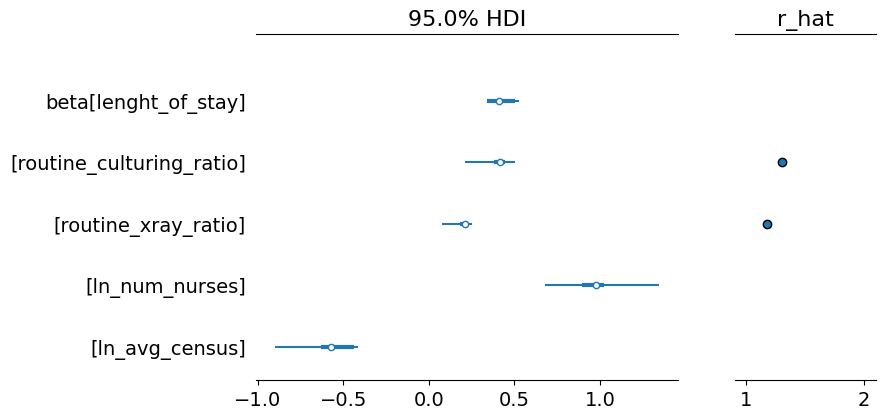

In [31]:
# Plot parameters for covariates
az.plot_forest(identified_sampling_result['df_top5'], var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);


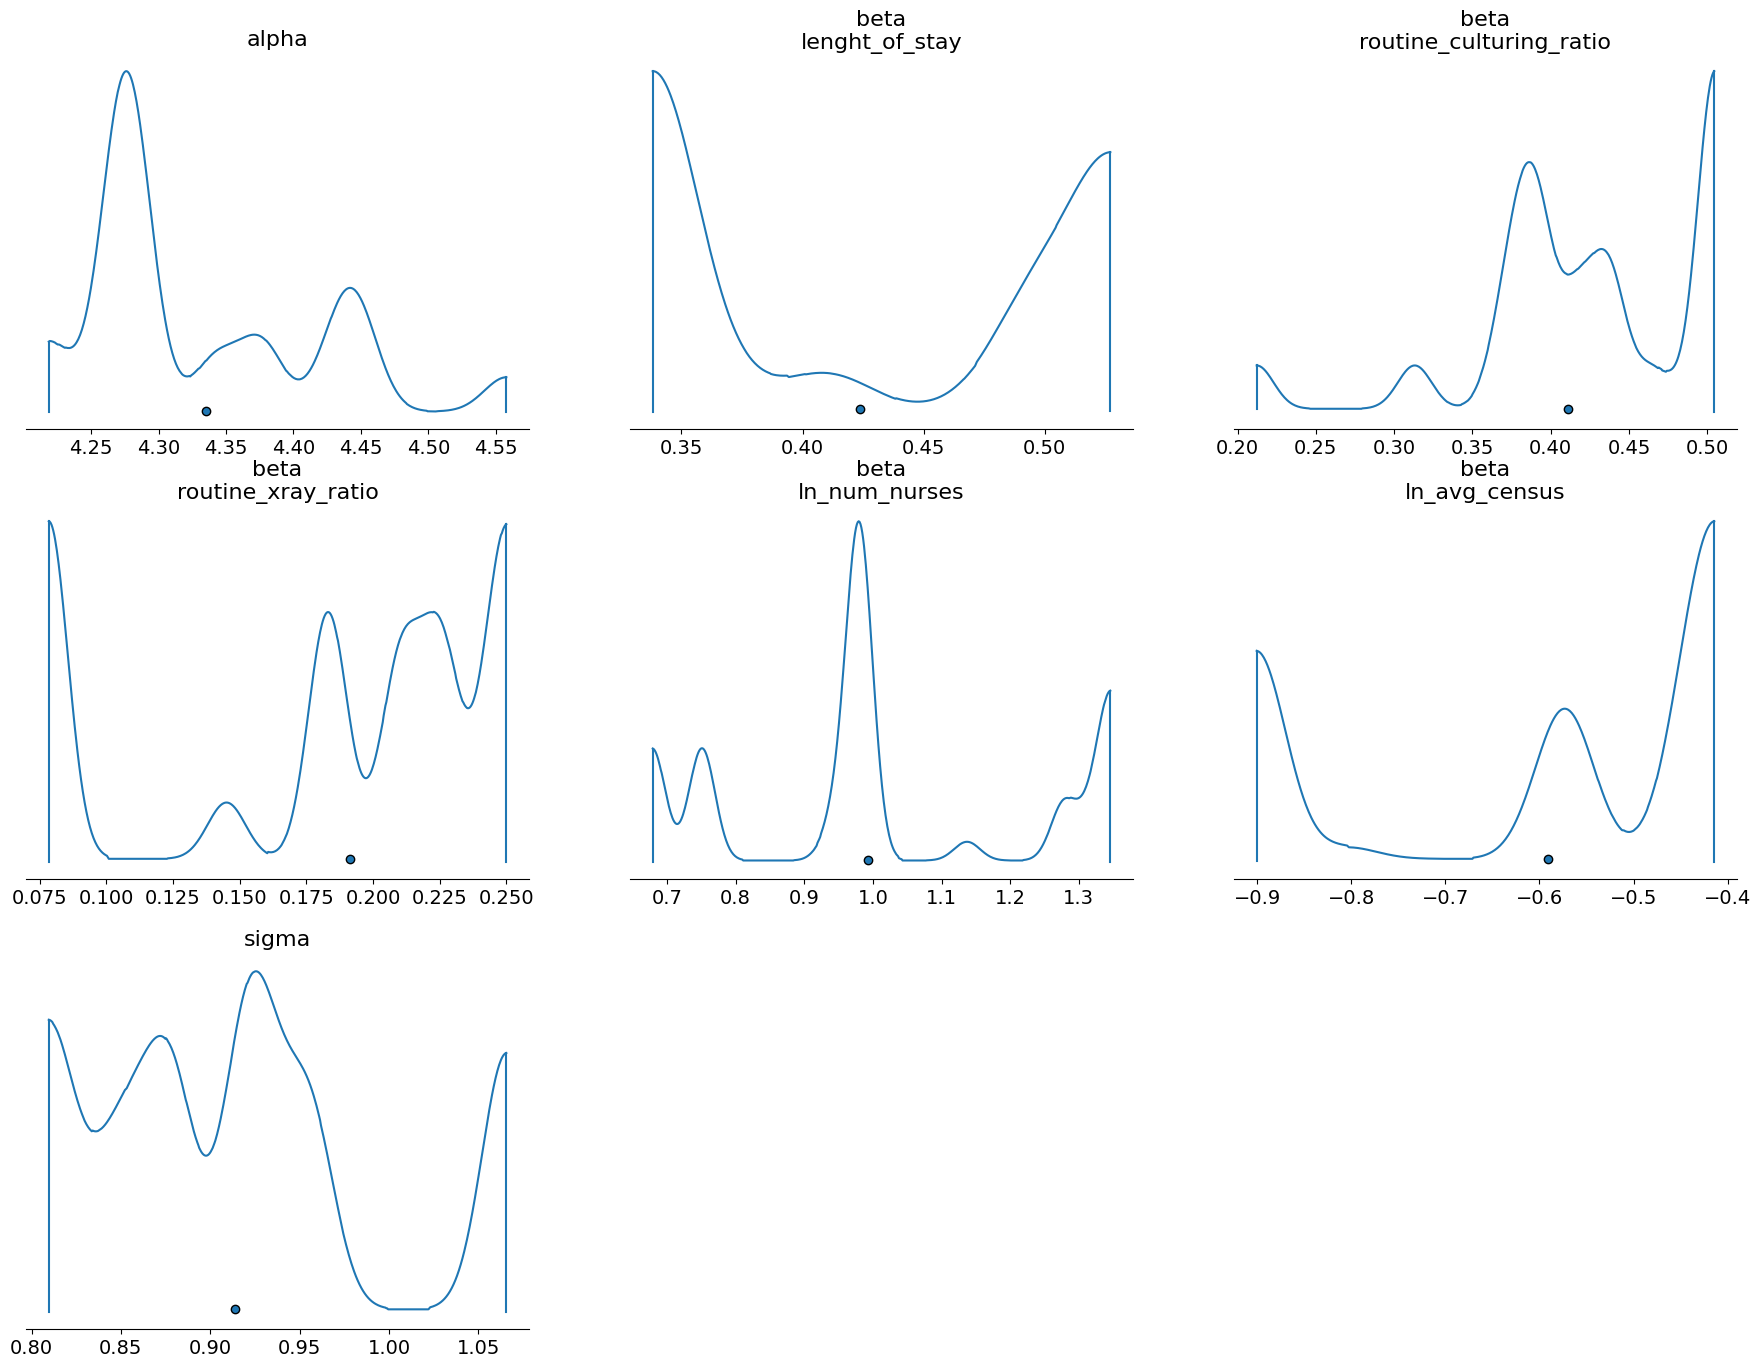

In [32]:
# Plot posterior densities of parameters
az.plot_density(identified_sampling_result['df_top5'], group='posterior', hdi_prob=0.95);

In [ ]:
Y_pred = pm.sample_posterior_predictive(identified_sampling_result['df_top5'], model=models[2]) # for each sample it draws a beta from each found beta distribution -> finds Y_pred for all X

Sampling: [Y_obs]


array([<Axes: xlabel='Y_obs / Y_obs'>], dtype=object)

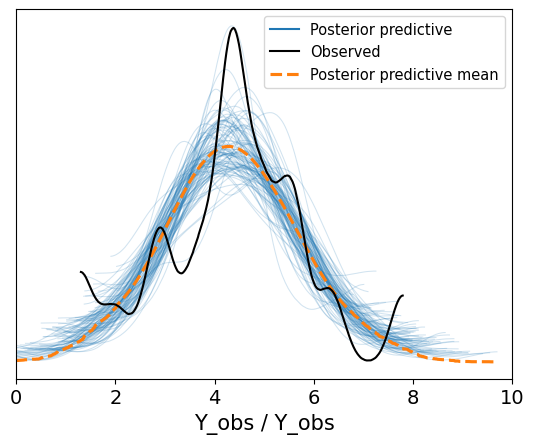

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.xlim(0,10)
az.plot_ppc(Y_pred, num_pp_samples=100, ax=ax)